# Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np
from scipy import stats
from scipy.stats import norm, kstest
import matplotlib
matplotlib.use('Agg')
import matplotlib.gridspec as gridspec

In [7]:
def empirical_quantile(X_col, val):
    """经验 CDF: q = P(X <= val)"""
    return float(np.mean(X_col <= val))

def random_projection_pit(X, y, M=200, seed=42):
    """
    返回:
      q_d    : 各维度边缘 PIT 分位数 (D,)
      q_proj : 随机投影 PIT 分位数   (M,)
    """
    N, D = X.shape
    rng = np.random.default_rng(seed)

    # 边缘 PIT
    q_d = np.array([empirical_quantile(X[:, d], y[d]) for d in range(D)])

    # 随机投影 PIT
    U = rng.normal(size=(M, D))
    U /= np.linalg.norm(U, axis=1, keepdims=True) + 1e-12
    sX = X @ U.T          # (N, M)
    sy = y @ U.T           # (M,)
    q_proj = np.mean(sX <= sy[None, :], axis=0)

    return q_d, q_proj


def plot_scenario(ax_marg, ax_proj, q_d, q_proj, title, alpha=0.90):
    """在两个 axes 上画边缘 PIT 和投影 PIT 的直方图"""
    lo, hi = (1 - alpha) / 2, 1 - (1 - alpha) / 2

    for ax, q, label in [(ax_marg, q_d, "Marginal PIT  $q_d$"),
                          (ax_proj, q_proj, "Projection PIT  $q^{(m)}$")]:
        ax.hist(q, bins=20, range=(0, 1), color="#5B9BD5", edgecolor="white", alpha=0.85)
        ax.axvline(lo, color="red", ls="--", lw=1.2, label=f"{lo:.2f}")
        ax.axvline(hi, color="red", ls="--", lw=1.2, label=f"{hi:.2f}")
        ax.axvline(0.5, color="grey", ls=":", lw=1)
        ax.set_xlim(0, 1)
        ax.set_xlabel(label)
        ax.set_ylabel("count")

    # 计算统计量
    lo, hi = 0.05, 0.95
    C_m = np.mean((q_d >= lo) & (q_d <= hi))
    C_p = np.mean((q_proj >= lo) & (q_proj <= hi))
    T_m = np.mean(np.abs(q_d - 0.5))
    T_p = np.mean(np.abs(q_proj - 0.5))

    ax_marg.set_title(f"{title}\nMarginal: C={C_m:.2f}, T={T_m:.3f}", fontsize=10)
    ax_proj.set_title(f"Projection: C={C_p:.2f}, T={T_p:.3f}", fontsize=10)


In [3]:
N = 2000
D = 33


In [8]:
A = np.random.randn(D, D) * 0.5
Sigma = A @ A.T + np.eye(D) * 0.3   # 正定
mu = np.zeros(D)

X_ref = np.random.multivariate_normal(mu, Sigma, size=N)

In [12]:
X_ref.shape

(2000, 33)

In [9]:
# y 就是从同一分布中抽取的
y1 = np.random.multivariate_normal(mu, Sigma)

In [13]:
y1.shape

(33,)

## Same distribution

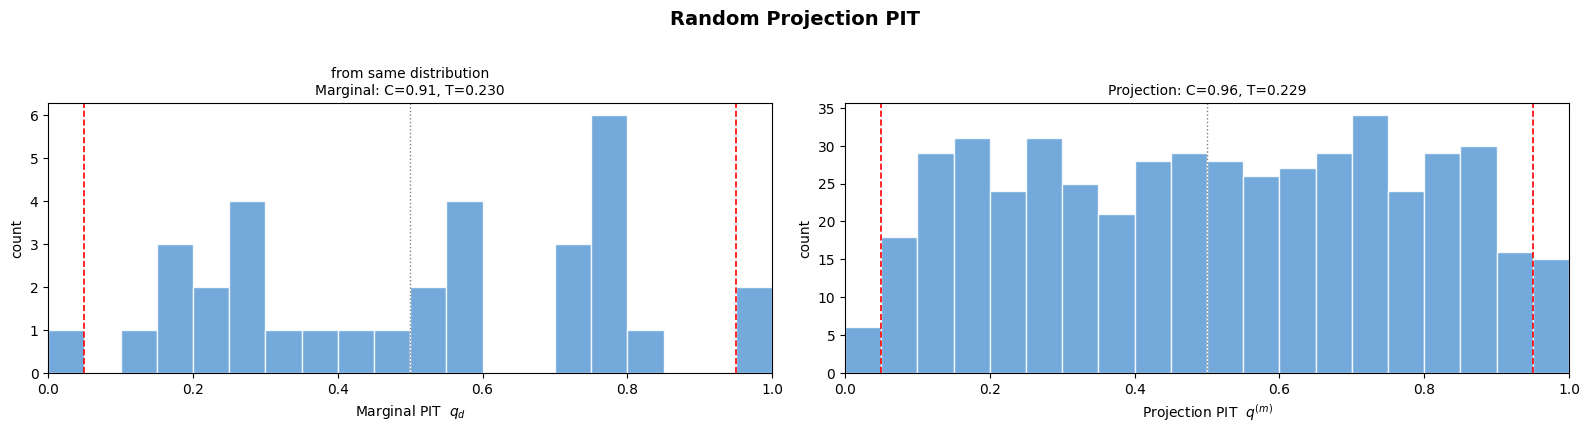

In [15]:
title1, y_vec1 = "from same distribution", y1

fig, (ax_m, ax_p) = plt.subplots(1, 2, figsize=(16, 4.2))
fig.suptitle("Random Projection PIT",
             fontsize=14, fontweight="bold", y=1.02)

q_d, q_proj = random_projection_pit(X_ref, y_vec1, M=500)
plot_scenario(ax_m, ax_p, q_d, q_proj, title1)

fig.tight_layout()
plt.show()

## Mean shift

In [21]:
y3 = np.random.multivariate_normal(mu + 2.5, Sigma * 0.3)

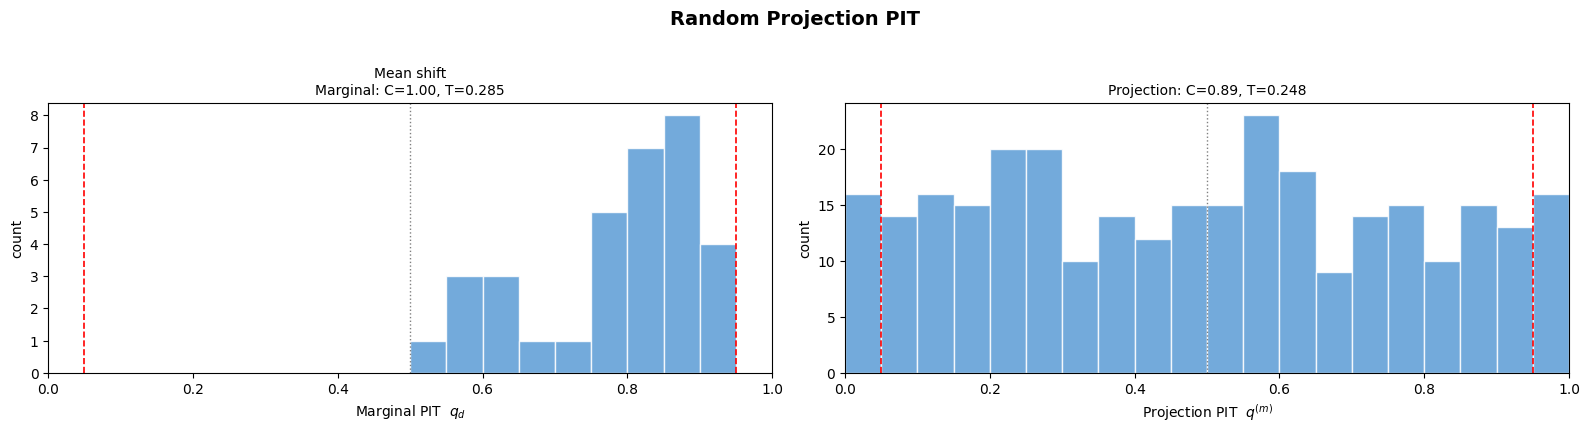

In [23]:
title1, y_vec1 = "Mean shift", y3

fig, (ax_m, ax_p) = plt.subplots(1, 2, figsize=(16, 4.2))
fig.suptitle("Random Projection PIT",
             fontsize=14, fontweight="bold", y=1.02)

q_d, q_proj = random_projection_pit(X_ref, y_vec1, M=300)
plot_scenario(ax_m, ax_p, q_d, q_proj, title1)

fig.tight_layout()
plt.show()

## Partial dimensional anomalies

In [24]:
y4 = np.random.multivariate_normal(mu, Sigma)
y4[:3] = mu[:3] + 4 * np.sqrt(np.diag(Sigma)[:3])

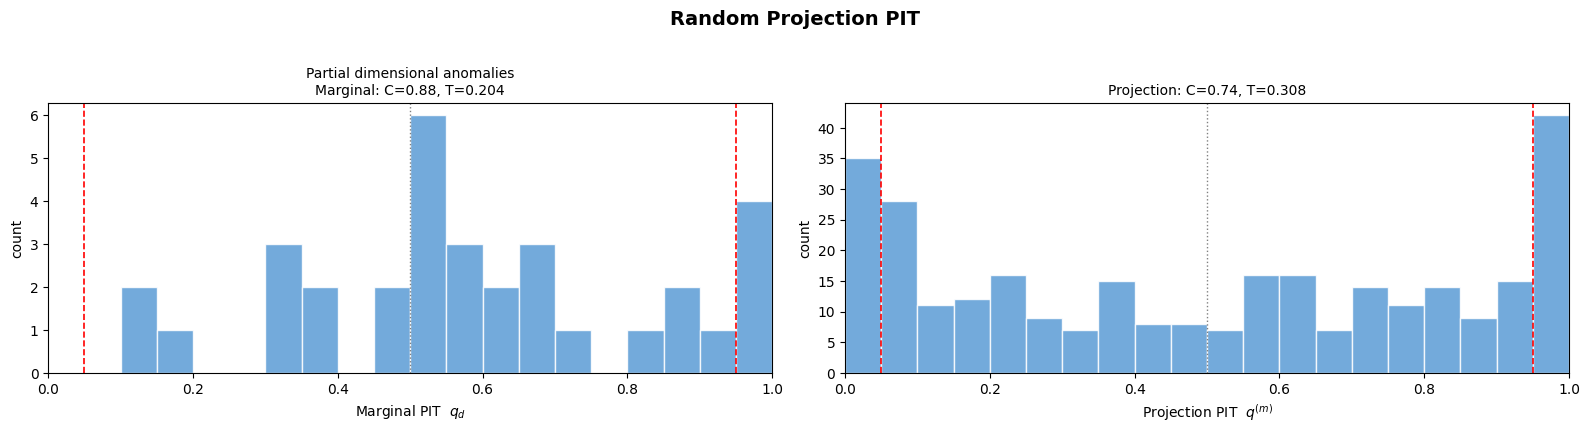

In [25]:
title1, y_vec1 = "Partial dimensional anomalies", y4

fig, (ax_m, ax_p) = plt.subplots(1, 2, figsize=(16, 4.2))
fig.suptitle("Random Projection PIT",
             fontsize=14, fontweight="bold", y=1.02)

q_d, q_proj = random_projection_pit(X_ref, y_vec1, M=300)
plot_scenario(ax_m, ax_p, q_d, q_proj, title1)

fig.tight_layout()
plt.show()

# RP-PIT Histogram

In [7]:
%matplotlib inline

In [4]:
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': '#fafafa',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 11,
})

COLORS = ['#2196F3', '#F44336', '#4CAF50', '#FF9800', '#9C27B0', '#795548']

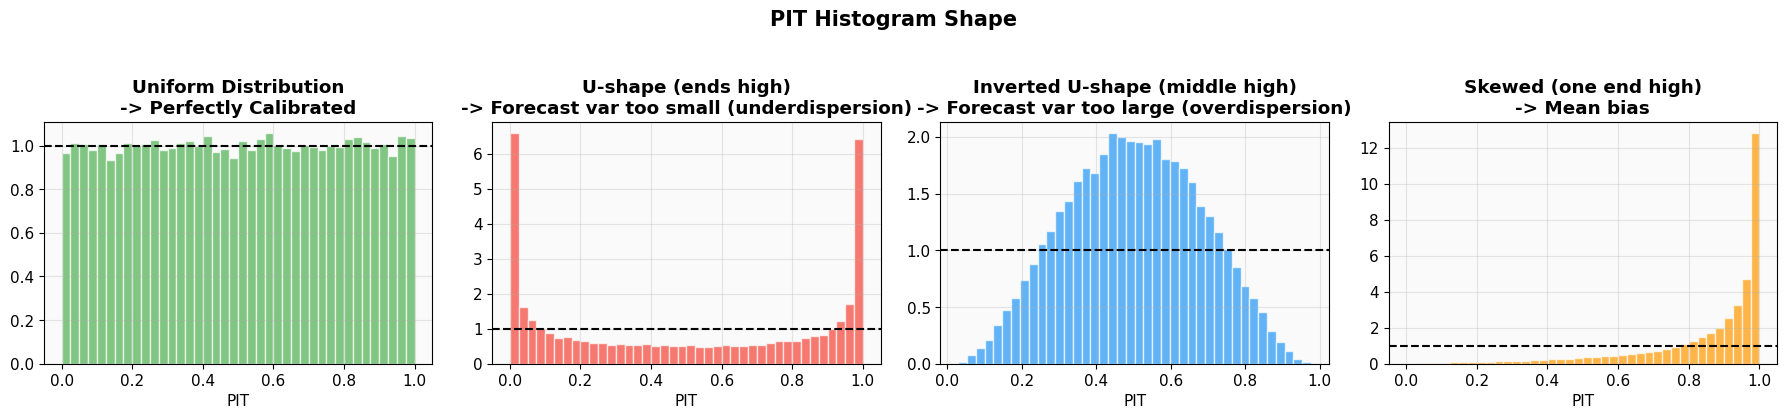

In [9]:

n = 50000
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# (a) Uniform — calibrated
pit = np.random.uniform(0, 1, n)
axes[0].hist(pit, bins=40, density=True, alpha=0.7, color=COLORS[2], edgecolor='white')
axes[0].axhline(1.0, color='black', ls='--', lw=1.5)
axes[0].set_title('Uniform Distribution\n-> Perfectly Calibrated', fontweight='bold')
axes[0].set_xlabel('PIT')

# (b) U-shape — underdispersion (forecast too narrow)
X = np.random.randn(n) * 2.0  # true std=2
pit = norm.cdf(X, 0, 1.0)      # forecast std=1 (too narrow)
axes[1].hist(pit, bins=40, density=True, alpha=0.7, color=COLORS[1], edgecolor='white')
axes[1].axhline(1.0, color='black', ls='--', lw=1.5)
axes[1].set_title('U-shape (ends high)\n-> Forecast var too small (underdispersion)', fontweight='bold')
axes[1].set_xlabel('PIT')

# (c) Inverted U — overdispersion (forecast too wide)
X = np.random.randn(n) * 0.5  # true std=0.5
pit = norm.cdf(X, 0, 1.0)      # forecast std=1 (too wide)
axes[2].hist(pit, bins=40, density=True, alpha=0.7, color=COLORS[0], edgecolor='white')
axes[2].axhline(1.0, color='black', ls='--', lw=1.5)
axes[2].set_title('Inverted U-shape (middle high)\n-> Forecast var too large (overdispersion)', fontweight='bold')
axes[2].set_xlabel('PIT')

# (d) Skewed — mean bias
X = np.random.randn(n) + 1.5  # true mean=1.5
pit = norm.cdf(X, 0, 1.0)      # forecast mean=0
axes[3].hist(pit, bins=40, density=True, alpha=0.7, color=COLORS[3], edgecolor='white')
axes[3].axhline(1.0, color='black', ls='--', lw=1.5)
axes[3].set_title('Skewed (one end high)\n-> Mean bias', fontweight='bold')
axes[3].set_xlabel('PIT')

fig.suptitle('PIT Histogram Shape', fontsize=15, fontweight='bold', y=1.04)
fig.tight_layout()
plt.show()

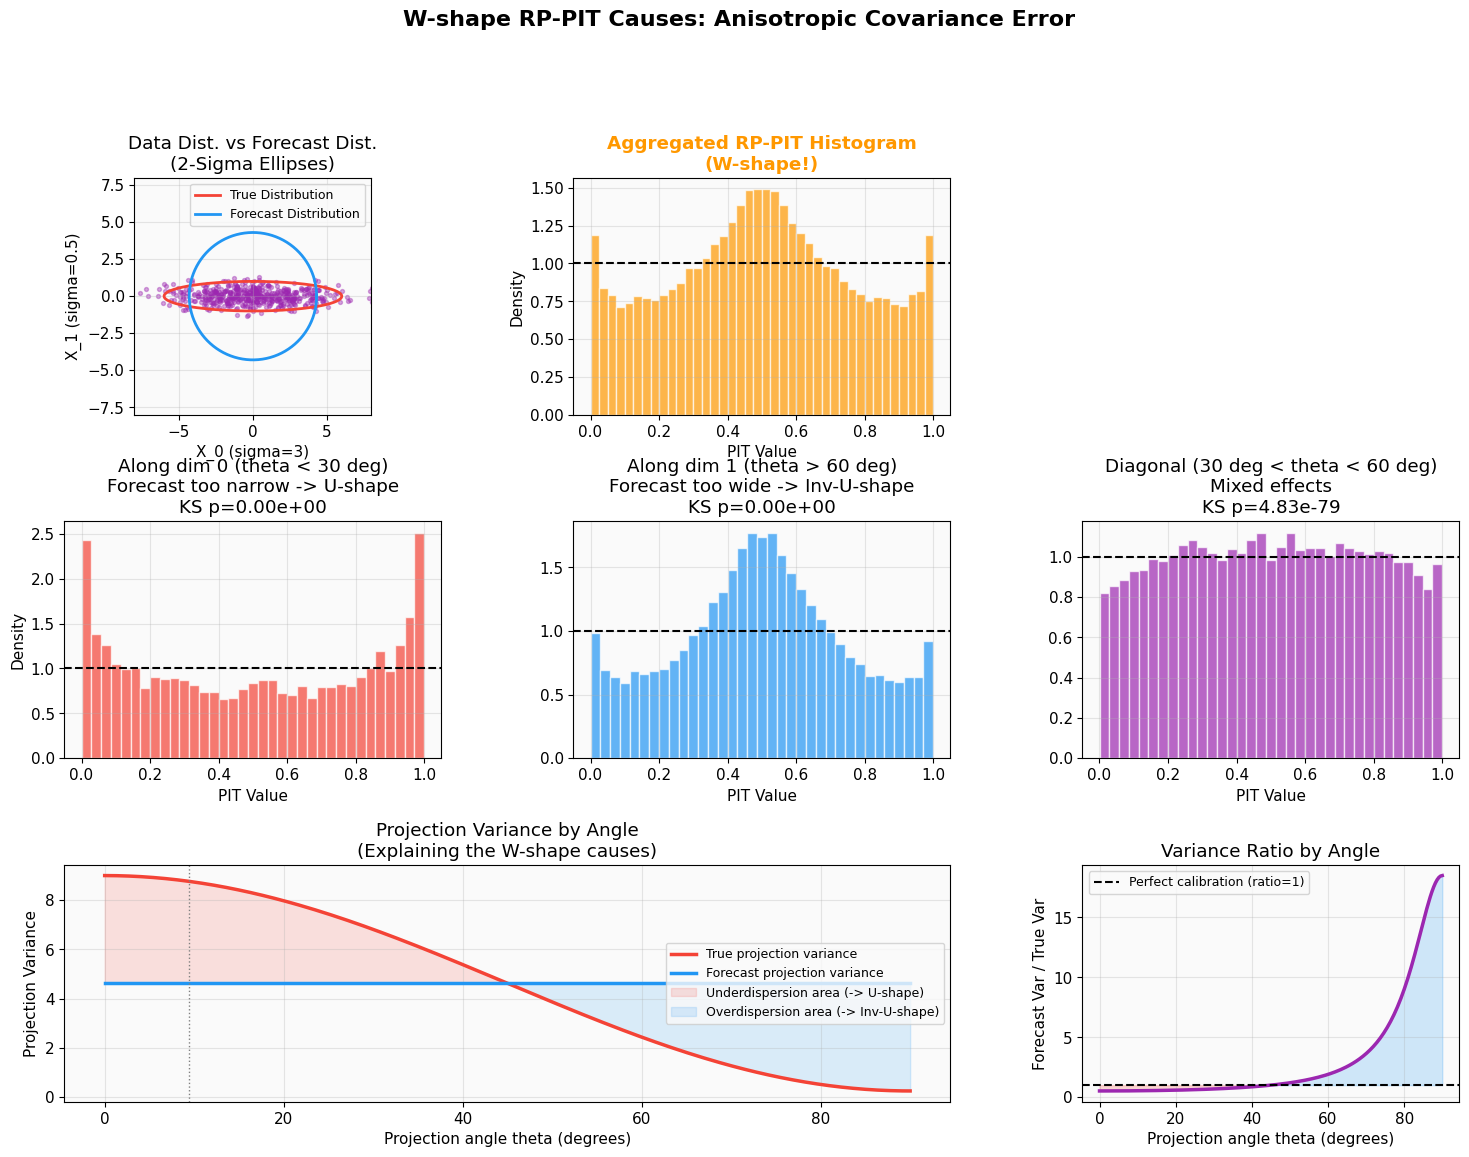

In [ ]:

n = 3000
d = 2

mu = np.zeros(d)
Sigma_true = np.array([[9.0, 0.0],   # σ₀=3
                        [0.0, 0.25]]) # σ₁=0.5

# Forecast: isotropic, but with "average" variance
avg_var = (9.0 + 0.25) / 2.0  # ≈ 4.625
Sigma_forecast = np.eye(d) * avg_var

L = np.linalg.cholesky(Sigma_true)
X = (L @ np.random.randn(d, n)).T

n_proj = 500
all_pits = []
pits_by_angle = {k: [] for k in ['near_dim0', 'near_dim1', 'diagonal']}
angles = []

for _ in range(n_proj):
    w = np.random.randn(d)
    w /= np.linalg.norm(w)
    angle = np.abs(np.arctan2(w[1], w[0]))  # angle with dim 0

    z = X @ w
    pm = w @ mu
    pv = w @ Sigma_forecast @ w
    pit = norm.cdf(z, loc=pm, scale=np.sqrt(pv))
    all_pits.extend(pit.tolist())
    angles.extend([angle] * n)

    # Categorize
    if angle < np.pi / 6:           # < 30° → near dim 0
        pits_by_angle['near_dim0'].extend(pit.tolist())
    elif angle > np.pi / 3:          # > 60° → near dim 1
        pits_by_angle['near_dim1'].extend(pit.tolist())
    else:
        pits_by_angle['diagonal'].extend(pit.tolist())

all_pits = np.array(all_pits)

# --- Plot ---
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(3, 3, hspace=0.45, wspace=0.35)

# (0,0) Scatter of data + forecast ellipse
ax00 = fig.add_subplot(gs[0, 0])
idx = np.random.choice(n, 500, replace=False)
ax00.scatter(X[idx, 0], X[idx, 1], s=8, alpha=0.4, color=COLORS[4])
# Draw ellipses
theta = np.linspace(0, 2*np.pi, 200)
for Sig, color, label in [(Sigma_true, COLORS[1], 'True Distribution'),
                            (Sigma_forecast, COLORS[0], 'Forecast Distribution')]:
    evals, evecs = np.linalg.eigh(Sig)
    a, b = 2*np.sqrt(evals)
    ell = evecs @ np.array([a*np.cos(theta), b*np.sin(theta)])
    ax00.plot(ell[0], ell[1], lw=2, color=color, label=label)
ax00.set_title('Data Dist. vs Forecast Dist.\n(2-Sigma Ellipses)')
ax00.set_xlabel('X_0 (sigma=3)')
ax00.set_ylabel('X_1 (sigma=0.5)')
ax00.legend(fontsize=9)
ax00.set_aspect('equal')
ax00.set_xlim(-8, 8)
ax00.set_ylim(-8, 8)

# (0,1) The aggregated W-shape RP-PIT
ax01 = fig.add_subplot(gs[0, 1])
ax01.hist(all_pits, bins=40, density=True, alpha=0.7, color=COLORS[3], edgecolor='white')
ax01.axhline(1.0, color='black', ls='--', lw=1.5)
ax01.set_title('Aggregated RP-PIT Histogram\n(W-shape!)', fontweight='bold', color=COLORS[3])
ax01.set_xlabel('PIT Value')
ax01.set_ylabel('Density')



# Row 2: Decomposition by angle
for col, (key, title, color) in enumerate([
    ('near_dim0', 'Along dim 0 (theta < 30 deg)\nForecast too narrow -> U-shape', COLORS[1]),
    ('near_dim1', 'Along dim 1 (theta > 60 deg)\nForecast too wide -> Inv-U-shape', COLORS[0]),
    ('diagonal',  'Diagonal (30 deg < theta < 60 deg)\nMixed effects', COLORS[4]),
]):
    ax = fig.add_subplot(gs[1, col])
    data = np.array(pits_by_angle[key])
    ax.hist(data, bins=35, density=True, alpha=0.7, color=color, edgecolor='white')
    ax.axhline(1.0, color='black', ls='--', lw=1.5)
    ks = kstest(data, 'uniform')
    ax.set_title(f'{title}\nKS p={ks.pvalue:.2e}')
    ax.set_xlabel('PIT Value')
    if col == 0:
        ax.set_ylabel('Density')

# Row 3: Variance ratio analysis
ax30 = fig.add_subplot(gs[2, 0:2])
angles_arr = np.linspace(0, np.pi/2, 200)
var_true_arr = []
var_forecast_arr = []
ratio_arr = []
for a in angles_arr:
    w = np.array([np.cos(a), np.sin(a)])
    vt = w @ Sigma_true @ w
    vf = w @ Sigma_forecast @ w
    var_true_arr.append(vt)
    var_forecast_arr.append(vf)
    ratio_arr.append(vf / vt)

ax30.plot(np.degrees(angles_arr), var_true_arr, lw=2.5, color=COLORS[1], label='True projection variance')
ax30.plot(np.degrees(angles_arr), var_forecast_arr, lw=2.5, color=COLORS[0], label='Forecast projection variance')
ax30.fill_between(np.degrees(angles_arr), var_true_arr, var_forecast_arr,
                    where=[vt > vf for vt, vf in zip(var_true_arr, var_forecast_arr)],
                    alpha=0.15, color=COLORS[1], label='Underdispersion area (-> U-shape)')
ax30.fill_between(np.degrees(angles_arr), var_true_arr, var_forecast_arr,
                    where=[vt < vf for vt, vf in zip(var_true_arr, var_forecast_arr)],
                    alpha=0.15, color=COLORS[0], label='Overdispersion area (-> Inv-U-shape)')
ax30.axvline(np.degrees(np.arctan(0.5/3)), color='grey', ls=':', lw=1)
ax30.set_xlabel('Projection angle theta (degrees)')
ax30.set_ylabel('Projection Variance')
ax30.set_title('Projection Variance by Angle\n(Explaining the W-shape causes)')
ax30.legend(fontsize=9, loc='center right')

# Variance ratio
ax31 = fig.add_subplot(gs[2, 2])
ax31.plot(np.degrees(angles_arr), ratio_arr, lw=2.5, color=COLORS[4])
ax31.axhline(1.0, color='black', ls='--', lw=1.5, label='Perfect calibration (ratio=1)')
ax31.fill_between(np.degrees(angles_arr), ratio_arr, 1.0,
                    where=[r > 1 for r in ratio_arr], alpha=0.2, color=COLORS[0])
ax31.fill_between(np.degrees(angles_arr), ratio_arr, 1.0,
                    where=[r < 1 for r in ratio_arr], alpha=0.2, color=COLORS[1])
ax31.set_xlabel('Projection angle theta (degrees)')
ax31.set_ylabel('Forecast Var / True Var')
ax31.set_title('Variance Ratio by Angle')
ax31.legend(fontsize=9)

fig.suptitle('W-shape RP-PIT Causes: Anisotropic Covariance Error',
                fontsize=16, fontweight='bold', y=1.02)
plt.show()


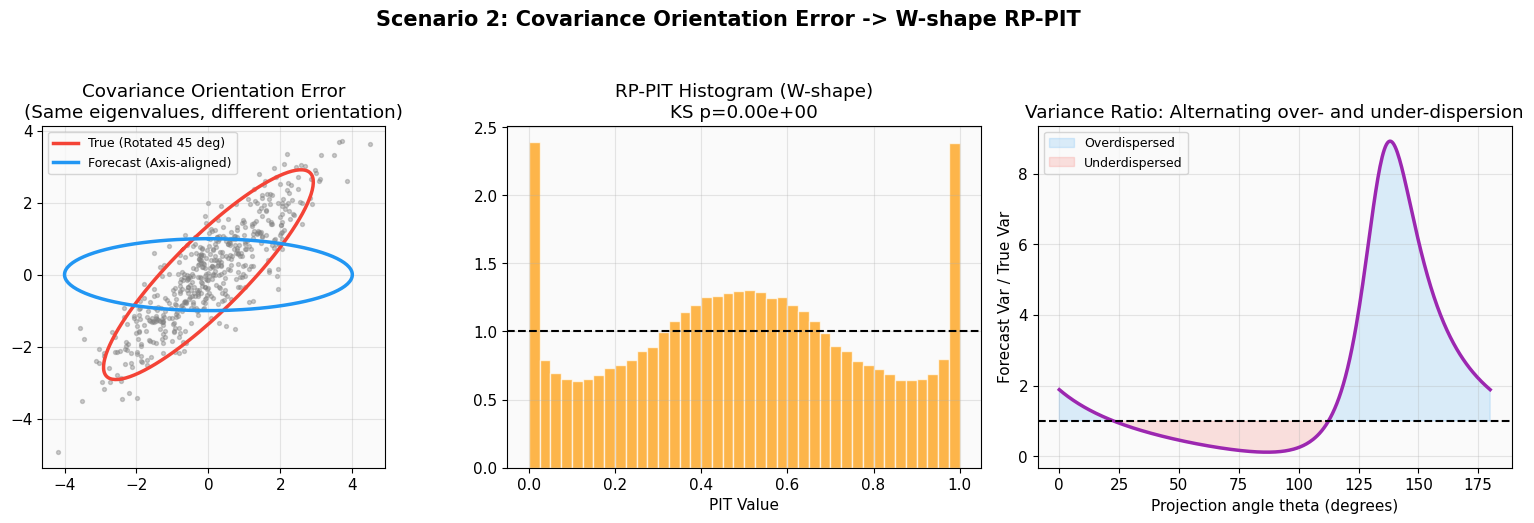

In [12]:

n = 3000
d = 2

eig1, eig2 = 4.0, 0.25  # eigenvalues (same for both)

# True: rotated 45°
angle_true = np.pi / 4
R_true = np.array([[np.cos(angle_true), -np.sin(angle_true)],
                    [np.sin(angle_true),  np.cos(angle_true)]])
Sigma_true = R_true @ np.diag([eig1, eig2]) @ R_true.T

# Forecast: axis-aligned (0°)
Sigma_forecast = np.diag([eig1, eig2])

mu = np.zeros(d)
L = np.linalg.cholesky(Sigma_true)
X = (L @ np.random.randn(d, n)).T

n_proj = 500
all_pits = []
for _ in range(n_proj):
    w = np.random.randn(d)
    w /= np.linalg.norm(w)
    z = X @ w
    pv = w @ Sigma_forecast @ w
    pit = norm.cdf(z, loc=0, scale=np.sqrt(pv))
    all_pits.extend(pit.tolist())
all_pits = np.array(all_pits)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Scatter + ellipses
idx = np.random.choice(n, 500, replace=False)
axes[0].scatter(X[idx, 0], X[idx, 1], s=8, alpha=0.4, color='grey')
theta = np.linspace(0, 2*np.pi, 200)
for Sig, color, label in [(Sigma_true, COLORS[1], 'True (Rotated 45 deg)'),
                            (Sigma_forecast, COLORS[0], 'Forecast (Axis-aligned)')]:
    evals, evecs = np.linalg.eigh(Sig)
    a, b = 2*np.sqrt(evals)
    ell = evecs @ np.array([a*np.cos(theta), b*np.sin(theta)])
    axes[0].plot(ell[0], ell[1], lw=2.5, color=color, label=label)
axes[0].set_aspect('equal')
axes[0].legend(fontsize=9)
axes[0].set_title('Covariance Orientation Error\n(Same eigenvalues, different orientation)')

# W-shape histogram
axes[1].hist(all_pits, bins=40, density=True, alpha=0.7, color=COLORS[3], edgecolor='white')
axes[1].axhline(1.0, color='black', ls='--', lw=1.5)
ks = kstest(all_pits, 'uniform')
axes[1].set_title(f'RP-PIT Histogram (W-shape)\nKS p={ks.pvalue:.2e}')
axes[1].set_xlabel('PIT Value')

# Variance ratio by angle
angles_arr = np.linspace(0, np.pi, 400)
ratios = []
for a in angles_arr:
    w = np.array([np.cos(a), np.sin(a)])
    ratios.append((w @ Sigma_forecast @ w) / (w @ Sigma_true @ w))
axes[2].plot(np.degrees(angles_arr), ratios, lw=2.5, color=COLORS[4])
axes[2].axhline(1.0, color='black', ls='--', lw=1.5)
axes[2].fill_between(np.degrees(angles_arr), ratios, 1.0,
                        where=[r > 1 for r in ratios], alpha=0.15, color=COLORS[0], label='Overdispersed')
axes[2].fill_between(np.degrees(angles_arr), ratios, 1.0,
                        where=[r < 1 for r in ratios], alpha=0.15, color=COLORS[1], label='Underdispersed')
axes[2].set_xlabel('Projection angle theta (degrees)')
axes[2].set_ylabel('Forecast Var / True Var')
axes[2].set_title('Variance Ratio: Alternating over- and under-dispersion')
axes[2].legend(fontsize=9)

fig.suptitle('Scenario 2: Covariance Orientation Error -> W-shape RP-PIT',
                fontsize=15, fontweight='bold', y=1.04)
fig.tight_layout()
plt.show()
